In [1340]:
from pynq import Overlay
### import libraries
import numpy as np
import decimal
from decimal import *
from datetime import datetime

# for printing out status reports
import sys
import time
import datetime

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [1341]:
overlay = Overlay('wavepredictor.bit')

In [1342]:
reset = 0x00
data_valid = 0x04
data_in = 0x08
yhat_valid = 0x0C
yhat_output = 0x10
read_start = 0x14
complete = 0x18
int_clear = 0x1C
read_addr = 0x20
output_mem = 0x24

In [1343]:
def data_write(x_input) :
    overlay.wavepredictor_0.write(data_in, x_input)
#    overlay.wavepredictor_0.write(data_in, x_input)
#    time.sleep(0.001)
    overlay.wavepredictor_0.write(data_valid, 0x0001)    
    overlay.wavepredictor_0.write(data_valid, 0x0000)
    return x_input

def output_read(address) :
    overlay.wavepredictor_0.write(read_addr, address)
#    overlay.wavepredictor_0.write(read_addr, address)
#    time.sleep(0.001)
    y = overlay.wavepredictor_0.read(output_mem)
#    time.sleep(0.001)
#    y = overlay.wavepredictor_0.read(output_mem)
#    overlay.wavepredictor_0.write(data_valid, 0x0000)
    return address,y

def twoscompl(y) :
    if y >= 2147483648:
        y = y - 4294967295 + 1
    else :
        y = y
    return y

In [1344]:
# import the data
N = 500
precision = 128
floatposition = 0  # full precision = 18

t = np.linspace(0,20*np.pi,N)
data = np.sin(t+np.cos(t))
data_fixed = np.multiply(data, precision)
data_fixed = np.round(data_fixed,floatposition)
data_fixed_16 = np.int16(data_fixed)

In [1345]:
overlay.wavepredictor_0.write(reset, 0x0000)

In [1346]:
overlay.wavepredictor_0.write(reset, 0x0001)

In [1347]:
for i in range(N):
    data_write(int(data_fixed_16[i]))
#    print(xinput)

In [1349]:
overlay.wavepredictor_0.write(read_start, 0x0001)
overlay.wavepredictor_0.write(read_start, 0x0000)
time0 = time.time()
flag = overlay.wavepredictor_0.read(complete)
print(flag)
sec_rtl = time.time()-time0
print(sec_rtl)
times_rtl = str(datetime.timedelta(seconds=sec_rtl)).split(".")
times_rtl = times_rtl[0]
print(times_rtl)

1
0.008013248443603516
0:00:00


In [1350]:
yhat = np.zeros(N,dtype=np.int)

for i in range(N):
    [i,y] = output_read(i)
#    print(y)
    yhat[i] = twoscompl(y)
#    print(yhat[i])

In [1351]:
# tanh's linear approximation
def tanh_func(x):
  if x < -384 : y = -128
  elif x > 384 : y = 128
  else : y= x
  return y

# network parameters
input_size =  1 # "channels" of data
num_hidden =  9 # breadth of model (number of units in hidden layers)
num_layers =  1 # depth of model (number of "stacks" of hidden layers)
seqlength  = 30 # number of datapoints used for learning in each segment
batchsize  =  1 # Note: the training code is actually hard-coded to organize data into batchsize=1

In [1352]:
Wih = np.array([[-0.49288213],[0.10480176],[0.03524816],[0.6232446 ],[0.19236483],[0.40054598],[0.5858149],[0.29669955],[0.1197296]])
bih = np.array([0.07013976, -0.07428959, 0.22870965, -0.04878226, 0.07275611, 0.21800387, 0.07693553, 0.05669446, 0.01514071])
Whh = np.array([[-0.14542736, 0.24339816, -0.33504033, -0.07390266, 0.09495462, 0.10659666, 0.00139894, 0.09115358, 0.16216579],
                [-0.20584649, -0.1981289, -0.28187597, -0.24111798, 0.11664228, 0.15862843, -0.07719703, 0.02340152, 0.21772884],
                [ 0.02603511, -0.05884702, -0.27324915, 0.05365919, 0.23594148, 0.13745816, -0.1916934, -0.04642, -0.2894646],
                [ 0.13850132, 0.21620858, 0.23422989, -0.1253775, 0.34796897, 0.1791737, 0.08457384, 0.03831204, -0.09143472],
                [ 0.33435392, -0.00450916, -0.32984832, -0.12475628, 0.0281543, 0.20769762, -0.14462334, -0.14027947, 0.3521123],
                [ 0.07547161, 0.19589093, -0.16741416, 0.24409811, -0.20972112, -0.25917363, 0.22263496, -0.41657072, 0.44981554],
                [-0.06636645, -0.04742345, 0.09547599, -0.09254519, 0.19047163, 0.24077152, -0.1239749, -0.2725863, 0.00527257],
                [ 0.10906798, 0.06842987, -0.18515381, 0.31988254, -0.04043828, 0.25423974, 0.3295134, 0.20589407, -0.16436236],
                [-0.14845392, -0.09020924, 0.17253236, -0.15588024, 0.07280625, -0.29569528, -0.06938756, -0.42582664, 0.26000705]])
bhh = np.array([ 0.30224848, -0.0035779, -0.32302895, 0.045023, -0.0212428, -0.06386401, 0.10403731, -0.23348783, -0.13923952])
Who = np.array([[-0.42396316, 0.07812572, -0.00577505, 0.658497, 0.23225583, 0.5478915, 0.61007863, 0.35252285, 0.14353535]])
bho = np.array([0.00258491])
Wih_fixed = np.float32(np.multiply(Wih,precision))
Wih_fixed = np.round(Wih_fixed,floatposition)
bih_fixed = np.float32(np.multiply(bih,precision))
bih_fixed = np.round(bih_fixed,floatposition)
Whh_fixed = np.float32(np.multiply(Whh,precision))
Whh_fixed = np.round(Whh_fixed,floatposition)
bhh_fixed = np.float32(np.multiply(bhh,precision))
bhh_fixed = np.round(bhh_fixed,floatposition)
Who_fixed = np.float32(np.multiply(Who,precision))
Who_fixed = np.round(Who_fixed,floatposition)
bho_fixed = np.float32(np.multiply(bho,precision))
bho_fixed = np.round(bho_fixed,floatposition)
Wih_fixed_16 = np.int16(Wih_fixed)
bih_fixed_16 = np.int16(bih_fixed)
Whh_fixed_16 = np.int16(Whh_fixed)
bhh_fixed_16 = np.int16(bhh_fixed)
Who_fixed_16 = np.int16(Who_fixed)
bho_fixed_16 = np.int16(bho_fixed)

WihXibih_min = np.zeros((num_hidden,),dtype=np.float32)    # Xi
WhhHibhh_min_prev = np.zeros((num_hidden,),dtype=np.float32)    # Hi
WhhHibhh_min = np.zeros((num_hidden,),dtype=np.float32)    # Hi
WhhHibhh_min_t = np.zeros((num_hidden,),dtype=np.float32)    # Hi
Hi_min_t = np.zeros((num_hidden,),dtype=np.float32)
Ho_min_t = np.zeros((num_hidden,),dtype=np.float32)          # Ho = tahn(WhhHibhh)
Ho_min = np.zeros((num_hidden,),dtype=np.float32)
YHAT_min = np.zeros((1,),dtype=np.float32)                  # Prediction
YHAT_min_result = np.zeros(N)

time0 = time.time()

for timei in range(N):
  data_test_in_min = data_fixed_16[timei]
#  print(data_test_in_min)
  for i in range(num_hidden):
      WihXibih_min[i] = Wih_fixed[i,0]*data_test_in_min/precision + bih_fixed[i]
#      print(Wih_fixed[i])
#  print(WihXibih_min)

  for i in range(num_hidden):
    if timei == 0:
      WhhHibhh_min[i] = bhh_fixed[i]
    else:
      WhhHibhh_min_t[i] = (Whh_fixed[i,0]*WhhHibhh_min_prev[0] + Whh_fixed[i,1]*WhhHibhh_min_prev[1] + Whh_fixed[i,2]*WhhHibhh_min_prev[2] + \
                        Whh_fixed[i,3]*WhhHibhh_min_prev[3] + Whh_fixed[i,4]*WhhHibhh_min_prev[4] + Whh_fixed[i,5]*WhhHibhh_min_prev[5] + \
                        Whh_fixed[i,6]*WhhHibhh_min_prev[6] + Whh_fixed[i,7]*WhhHibhh_min_prev[7] + Whh_fixed[i,8]*WhhHibhh_min_prev[8])/precision
      WhhHibhh_min[i] = WhhHibhh_min_t[i] + bhh_fixed[i]
    WhhHibhh_min_prev[i] = WhhHibhh_min[i]
  #print(Whh_fixed)
  #print(np.int32(WhhHibhh_min_t))
  #print(np.int32(WhhHibhh_min_prev))

  for i in range(num_hidden):
    Hi_min_t[i] = (WhhHibhh_min[i] + WihXibih_min[i])
    Ho_min[i] = tanh_func((WhhHibhh_min[i] + WihXibih_min[i])/np.float32(precision)) * np.float32(precision)

  YHAT_min = (Who_fixed[0,0]*Ho_min[0] + Who_fixed[0,1]*Ho_min[1] + Who_fixed[0,2]*Ho_min[2] + Who_fixed[0,3]*Ho_min[3] + Who_fixed[0,4]*Ho_min[4] + \
                Who_fixed[0,5]*Ho_min[5] + Who_fixed[0,6]*Ho_min[6] + Who_fixed[0,7]*Ho_min[7] + Who_fixed[0,8]*Ho_min[8])/np.float32(precision) + bho_fixed[0]
  YHAT_min_result[timei] = YHAT_min
#  print(YHAT_min)


sec_system = time.time()-time0
print(sec_system)
times_system = str(datetime.timedelta(seconds=sec_system)).split(".")
times_system = times_system[0]
print(times_system)

1.472517967224121
0:00:01


SW run time =  1.472517967224121
RTL run time =  0.008013248443603516


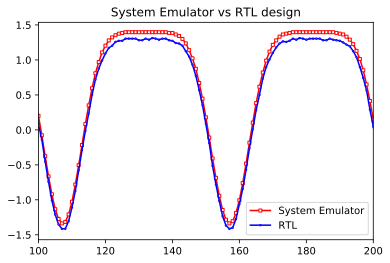

In [1354]:
#plt.figure(figsize=(15,4))
print("SW run time = ", sec_system)
print("RTL run time = ", sec_rtl)

plt.plot(np.multiply(YHAT_min_result[30:],1/precision),'rs-',markerfacecolor='w', label='System Emulator',markersize=3)
plt.plot(np.multiply(yhat[30:],1/precision),'b.-',markerfacecolor='w', label='RTL',markersize=3)
plt.xlim([-5,N+4])
plt.xlim([100,200])
plt.legend()
plt.title('System Emulator vs RTL design')
plt.show()

In [1355]:
overlay.wavepredictor_0.read(complete)

1

In [1356]:
overlay.wavepredictor_0.write(data_valid, 0x0000)
overlay.wavepredictor_0.write(int_clear, 0x0001)
overlay.wavepredictor_0.write(int_clear, 0x0000)

In [1357]:
overlay.wavepredictor_0.read(complete)

0